This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# Effective-True 𝑓_NL

This ipynb provides the code necessary to compute 
- the Power Spectrum (PS) of the Local Primordial Non-Gaussianities (PNG);
- the Power Spectrum made by the sum of 25 General Relativistic (GR) effects arising from the relativistic Galaxy Number Counts (GNC);
- the Power Spectra of the standard Newtonian (the leading GR effect) and of the Galaxies in the Plane-Parallel (PP) approximation.

The PNG are described in the $f_{\rm NL}$ prescription, where the primordial gravitational potential during the matter domination $\Phi_{\rm NG}(s)$ includes a quadratic correction:

$$ \Phi_{\rm NG}(s) = \phi_{\rm G}(s) + f_{\rm NL} \left[ \phi^2_G(s) - \phi^2_{\rm G}(s)\right]$$


where $\phi_{\rm G}$ indicates the primordial potential assumed to be a Gaussian random field, $\langle ...\rangle$ denotes ensemble average and $f_{\rm NL}$ describes the amplitude of the correction.


All the output files will be placed in the following directory:

In [1]:
#DIR = "/Users/matteofoglieni/Dropbox/GR_effects/Matteo_Output/fNL_effective_z115/";
DIR = "Effective-True_fNL_z115_files/";

ps_kwargs(twofast::Bool) = twofast ?
    Dict(:twofast=>true, :epl => true, :pr => false, 
          :N_left => 12, :N_right => 12,
          :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
          :int_s_min => 1e0, :int_s_max => 1200.0) :
    Dict(:twofast=>false, :pr=>true, :ν => 1.5, :n_extrap_low => 0,
     :n_extrap_high => 0, :n_pad => 500, :cut_first_n=>6);
tf = false;

## Basic Framework

In [2]:
PATH_TO_GAPSE = "../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, TwoFAST, ProgressMeter
using Printf, LaTeXStrings, Turing, StatsPlots, GridInterpolations, LegendrePolynomials
pyplot()

Plots.PyPlotBackend()

In [5]:
#z_min, z_max, θ_max = 0.05, 0.20, π / 2.0
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

WFI_opts = Dict(
    :ss_start => 0.0, :ss_stop => 0.0, 
    :ss_step => 50, :llim => 0.0, :rlim => Inf, 
    :rtol => 5e-2, :atol => 0.0, :N => 1000, #:pr => true,
)

FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt"
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt"
FILE_BACKGROUND = PATH_TO_GAPSE * "test/datatest/WideA_ZA_background.dat"

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.0,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    WFI_opts = WFI_opts,
);

In [6]:
#=
new_calc_μs = union([μ for μ in -1.0:0.01:(-0.9)], 
        [μ for μ in -0.9:0.05:0.9], 
        [μ for μ in 0.9:0.01:1.0]);
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"

GaPSE.print_map_IntegratedF(
    FILE_F_MAP, FILE_IF_MAP, 
    z_min, z_max, new_calc_μs, FILE_BACKGROUND;
    trap = true, WFI_opts...
)
=#

In [7]:
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntF_pi2_z115.txt"
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../test/datatest/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntF_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.0 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - CosmoParams about the Integrated Window Function F: 
#	 ss_step = 50 	 N = 1000 	 rtol = 0.05

## Check window function F an integrated IF

In [8]:
#=
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);
=#

In [9]:
#=
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);
=#

In [10]:
#=
p1 = plot(my_xs, my_μs, my_Fs; xl="s", yl="μ", zl="int", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my IntF", legend = false)
plot(p1, p2, size=(1200, 400))
=#

In [11]:
#=
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]
for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))
=#

In [12]:
#=
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

θ_max =  π/2.0;
ss = vcat([10.0], [i*max(my_Iss...)/6 for i in 1:5]);
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = "\n\n s = $s [Mpc/h_0]"
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))
=#

## Creation of a CosmoPNG struct

In [13]:
cosmopng = GaPSE.CosmoPNG(cosmo, PATH_TO_GAPSE*"data/Tk.dat");

In [14]:
func(z) = cosmo.D_of_s(cosmo.s_of_z(z)) * (1+z) * 0.779017;

In [15]:
func(6.2387072)

0.999999999990678

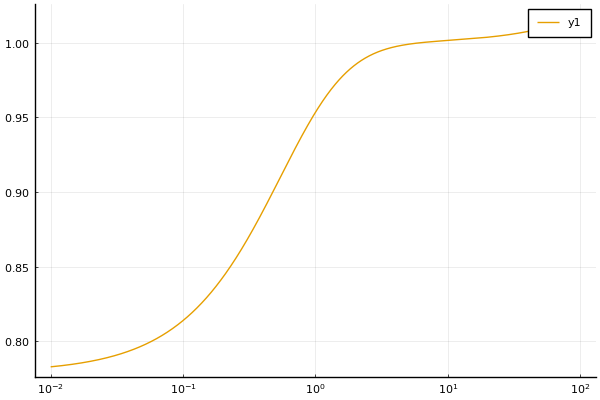

In [16]:
zs = 10.0 .^ range(-2,2, length=1000)#0.779017
plot(zs, func.(zs), xaxis=:log)

In [17]:
#ks_tf, pks_tf = GaPSE.readxy("../data/Tk.dat");
#T = Spline1D(ks_tf, pks_tf; bc ="error");
ks_all_tf, pks_all_tf = GaPSE.readxall(PATH_TO_GAPSE*"data/WideA_ZA_tk.dat", comments=true);
orig_T = Spline1D(ks_all_tf, pks_all_tf[end]; bc ="error");

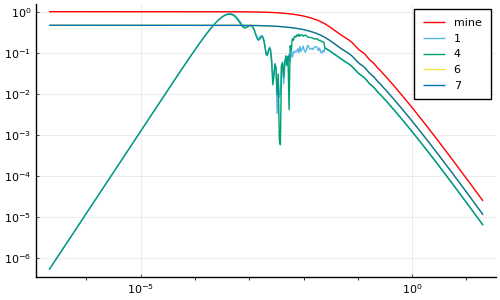

In [18]:
P = plot(ks_all_tf, cosmopng.tf.(ks_all_tf), axis=:log, label="mine", size=(500, 300), lc=:red)
for i in [1, 4, 6,7]
    plot!(P,ks_all_tf, abs.(pks_all_tf[i]), label="$i")
end
P

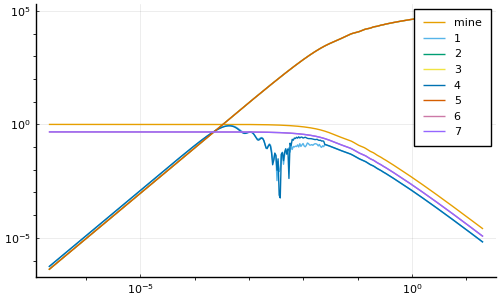

In [19]:
P = plot(ks_all_tf, cosmopng.tf.(ks_all_tf), axis=:log, label="mine", size=(500, 300))
for (i, ys) in enumerate(pks_all_tf)
    plot!(P, ks_all_tf, abs.(ys), label="$i")
end
P

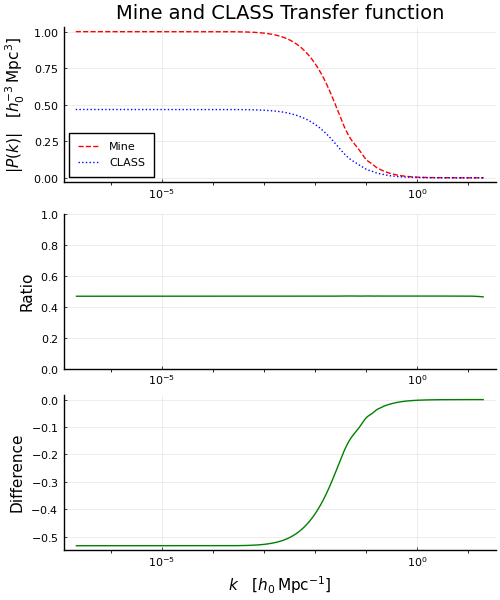

In [20]:
xs_1 = ks_all_tf
ys_1 = cosmopng.tf.(ks_all_tf)

xs_2 = ks_all_tf
ys_2 =  abs.(pks_all_tf[7]) 
spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "Mine and CLASS Transfer function",
    label=["Mine" "CLASS"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0,1), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
p3 = plot(xs_1, spline.(xs_1) .- ys_1, 
    ylabel="Difference", lc=:green, 
    xaxis=:log,
    #ylim=(0.0,1), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#display(P)

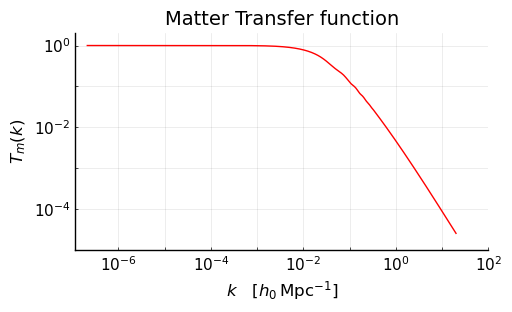

In [21]:
xs_1 = ks_all_tf
ys_1 = cosmopng.tf.(ks_all_tf)


S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_1, abs.(ys_1),
    xaxis=:log, yaxis=:log, 
    lc=:red, size=(500, 300), ylim=(1e-5, 2e0),
    yticks = (
        [10.0 ^ i for i in -5:0], 
        [i%2==0 ? L"10^{%$i}" : nothing for i in -5:0]),
    xticks = (
        [10.0 ^ i for i in -6:2], 
        [i%2==0 ? L"10^{%$i}" : nothing for i in -6:2]),
    title = "Matter Transfer function",
    ls=:solid, tickfontsize=11, labelfontsize=12,
    ylabel = L"T_m(k)", xlabel = L"k \quad [h_0\, \mathrm{Mpc}^{-1}]",
    legend=false)
savefig(p1, DIR*"Matter_Transfer_Function.pdf")

## Code GNCsum and Newtonian TPCF and PS L=0 with F

In [22]:
name_xis_GNC_file = "map_sum_xis_GNC_L0_withF.txt";
name_ps_GNC_file ="map_sum_ps_GNC_L0_withF.txt";

In [23]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*name_xis_GNC_file, 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    single = true, use_windows = true, enhancer = 1e8, L=0,
    N_μs = 200, μ_atol = 0.0, μ_rtol = 1e-2, trap = true,
    N_χs = 100, N_χs_2 = 60);
=#

In [24]:
ss_GNC_L0_withF, xis_sum_GNC_L0_withF, all_xis_GNC_L0_withF = 
    GaPSE.readxyall(DIR*name_xis_GNC_file);
spline_GNCsum_L0_withF = Spline1D(ss_GNC_L0_withF, xis_sum_GNC_L0_withF; bc = "error");

In [25]:
GaPSE.print_all_PS_multipole(DIR*name_xis_GNC_file, 
    DIR*name_ps_GNC_file, "GNC"; L=0, ps_kwargs(tf)...)
ks_GNC_L0_withF, pks_sum_GNC_L0_withF, pks_all_GNC_L0_withF = 
    GaPSE.readxyall(DIR*name_ps_GNC_file);


I'm computing the PS_multipole from the file "Effective-True_fNL_z115_files/map_sum_xis_GNC_L0_withF.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 2.5856010913848877



In [26]:
#ks_Newtonian_L0_withF, pks_Newtonian_L0_withF = GaPSE.PS_multipole(ss_GNC_L0_withF, 
#    all_xis_GNC_L0_withF[1]; L = 0,  ps_kwargs(tf)...);
ks_Newtonian_L0_withF, pks_Newtonian_L0_withF = 
    ks_GNC_L0_withF, pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]];
spline_Newt_L0_withF = Spline1D(ks_Newtonian_L0_withF, pks_Newtonian_L0_withF; bc = "error");

## S monopole and dipole

In [27]:
ss = 10 .^ range(-3,4; length=300);
J0s = [cosmopng.J0(s) for s in ss]
J2s = [cosmopng.J2(s) for s in ss]
I02s = [cosmo.tools.I02(s) * s^2 for s in ss]; 
I22s = [cosmo.tools.I22(s) * s^2 for s in ss]; 

In [28]:
3/2*cosmo.params.Ω_M0/0.779017/cosmo.D_of_s(0), 0.779017^2

(0.5774970250970135, 0.6068674862889999)

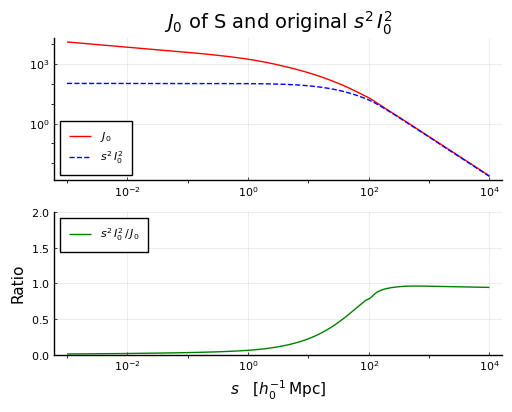

In [29]:
xs_1 = ss
ys_1 = J0s ./ (100 / 299792.458) .^2

xs_2 = ss
ys_2 = I02s
spline_2 = Spline1D(xs_2, ys_2)

#xs_3 = casto_ss
#ys_3 = abs.(casto_J0s) ./ (100 / 299792.458) .^2
#spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_0"*" of S and original " * L"s^2 \, I_0^2",
    label=[L"J_0" L"s^2 \, I_0^2"], ls=[:solid :dash], 
    legend=:bottomleft)
#plot!(p1, xs_3, ys_3, label = "casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = L" s^2 \, I_0^2 \, / \, J_0",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
#plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J0_of_S.pdf")

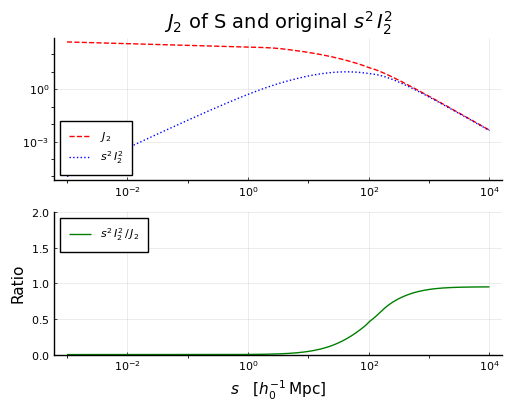

In [30]:
xs_1 = ss
ys_1 = J2s ./ (100 / 299792.458) .^2  #.* 1e13

xs_2 = ss
ys_2 = I22s
spline_2 = Spline1D(xs_2, ys_2)

#xs_3 = casto_ss
#ys_3 = abs.(casto_J2s) ./ (100 / 299792.458) .^2
#spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_2"*" of S and original " * L"s^2 \, I_2^2",
    label=[L"J_2" L"s^2 \, I_2^2"], ls=[:dash :dot], 
    legend=:bottomleft)
#plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = L"s^2 \, I_2^2 \,  / \, J_2",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
#plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J2_of_S.pdf")

## Code TPCF and PS of S

In [31]:
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "map_xi_S_L0_noF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=0, use_windows = false);
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "map_xi_S_L2_noF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=2, use_windows = false);
GaPSE.print_PS_multipole(DIR * "map_xi_S_L0_noF.dat", 
    DIR * "map_ps_S_L0_noF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR * "map_xi_S_L2_noF.dat", 
    DIR * "map_ps_S_L2_noF.dat"; L = 2, ps_kwargs(tf)...);

ss_S_L0_noF, xis_S_L0_noF = GaPSE.readxy(DIR * "map_xi_S_L0_noF.dat");
ss_S_L2_noF, xis_S_L2_noF = GaPSE.readxy(DIR * "map_xi_S_L2_noF.dat");
ks_S_L0_noF, pks_S_L0_noF = GaPSE.readxy(DIR * "map_ps_S_L0_noF.dat");
ks_S_L2_noF, pks_S_L2_noF = GaPSE.readxy(DIR * "map_ps_S_L2_noF.dat");

ξ_S, L=0: 100%|█████████████████████████████████████████| Time: 0:00:01



time needed for map_ξ_S_multipole [in s] = 1.10679 

time needed for map_ξ_S_multipole [in s] = 0.05140 

I'm computing the PS_multipole from the file "Effective-True_fNL_z115_files/map_xi_S_L0_noF.dat" 

time needed for this Power Spectrum computation [in s] = 0.002022981643676758


I'm computing the PS_multipole from the file "Effective-True_fNL_z115_files/map_xi_S_L2_noF.dat" 

time needed for this Power Spectrum computation [in s] = 0.0020940303802490234



In [32]:
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "map_xi_S_L0_withF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=0, use_windows = true);
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "map_xi_S_L2_withF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=2, use_windows = true);
GaPSE.print_PS_multipole(DIR * "map_xi_S_L0_withF.dat", 
    DIR * "map_ps_S_L0_withF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR * "map_xi_S_L2_withF.dat", 
    DIR * "map_ps_S_L2_withF.dat"; L = 2, ps_kwargs(tf)...);

ss_S_L0_withF, xis_S_L0_withF = GaPSE.readxy(DIR * "map_xi_S_L0_withF.dat");
ss_S_L2_withF, xis_S_L2_withF = GaPSE.readxy(DIR * "map_xi_S_L2_withF.dat");
ks_S_L0_withF, pks_S_L0_withF = GaPSE.readxy(DIR * "map_ps_S_L0_withF.dat");
ks_S_L2_withF, pks_S_L2_withF = GaPSE.readxy(DIR * "map_ps_S_L2_withF.dat");

ξ_S, L=0: 100%|█████████████████████████████████████████| Time: 0:00:02



time needed for map_ξ_S_multipole [in s] = 2.02093 


ξ_S, L=2: 100%|█████████████████████████████████████████| Time: 0:00:07



time needed for map_ξ_S_multipole [in s] = 7.84834 

I'm computing the PS_multipole from the file "Effective-True_fNL_z115_files/map_xi_S_L0_withF.dat" 

time needed for this Power Spectrum computation [in s] = 0.0031778812408447266


I'm computing the PS_multipole from the file "Effective-True_fNL_z115_files/map_xi_S_L2_withF.dat" 

time needed for this Power Spectrum computation [in s] = 0.002537965774536133



## Check Plot S multipoles

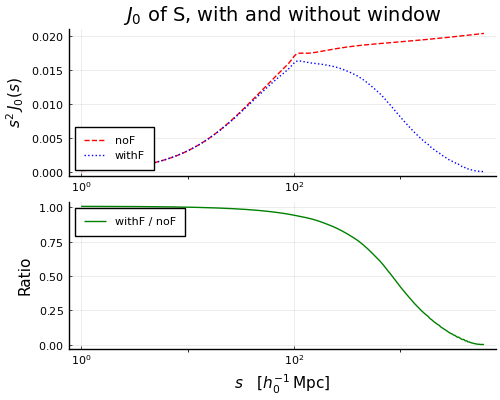

In [33]:
xs_1 = ss_S_L0_noF
ys_1 = xis_S_L0_noF .* xs_1 .^ 2

xs_2 = ss_S_L0_withF 
ys_2 = xis_S_L0_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_0"*" of S, with and without window",
    label=["noF" "withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, J_0(s)",
    legend=:bottomleft)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "withF / noF",
    #ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )

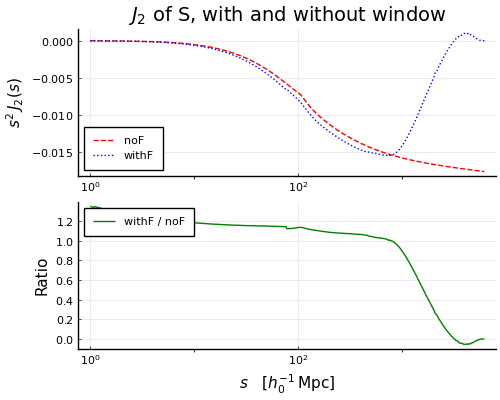

In [34]:
xs_1 = ss_S_L2_noF
ys_1 = xis_S_L2_noF .* xs_1 .^ 2

xs_2 = ss_S_L2_withF 
ys_2 = xis_S_L2_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_2"*" of S, with and without window",
    label=["noF" "withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, J_2(s)",
    legend=:bottomleft)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "withF / noF",
    #ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )

## Code for the computation of the Plain-Parallel Galaxies multipoles

In [ ]:
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, DIR*"map_xi_ppg_L0_withF.dat",
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, DIR*"map_xi_ppg_L2_withF.dat",
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 2, use_windows = true, pr = true, enhancer = 1e6,
    μ_atol = 0.0, μ_rtol = 1e-2);
GaPSE.print_PS_multipole(DIR*"map_xi_ppg_L0_withF.dat", 
    DIR*"map_ps_ppg_L0_withF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR*"map_xi_ppg_L2_withF.dat", 
    DIR*"map_ps_ppg_L2_withF.dat"; L = 2, ps_kwargs(tf)...);

ss_ppg_L0_withF, xis_ppg_L0_withF = GaPSE.readxy(DIR*"map_xi_ppg_L0_withF.dat");
ss_ppg_L2_withF, xis_ppg_L2_withF = GaPSE.readxy(DIR*"map_xi_ppg_L2_withF.dat");
ks_ppg_L0_withF, pks_ppg_L0_withF = GaPSE.readxy(DIR*"map_ps_ppg_L0_withF.dat");
ks_ppg_L2_withF, pks_ppg_L2_withF = GaPSE.readxy(DIR*"map_ps_ppg_L2_withF.dat");

spline_ppg_L0_withF = Spline1D(ks_ppg_L0_withF, pks_ppg_L0_withF; bc = "error");

PP Galaxies, L=0: 100%|█████████████████████████████████| Time: 0:00:04



time needed for map_ξ_PPGalaxies_multipole [in s] = 4.33871 


PP Galaxies, L=2:  89%|█████████████████████████████▍   |  ETA: 0:00:01

## Code for the differences Newt-ppg, GNCsum-Newt and GNCsum-ppg

In [ ]:
ks = ks_GNC_L0_withF
diff_Newt_ppg =  pks_Newtonian_L0_withF .- pks_ppg_L0_withF;
#diff_ALLGRsum_ppg = pks_ALLGRsum_L0_withF .- pks_ppg_L0_withF;
#diff_ALLGRsum_Newt = pks_ALLGRsum_L0_withF .- pks_Newtonian_L0_withF;
diff_GNCsum_ppg = pks_sum_GNC_L0_withF .- pks_ppg_L0_withF;
diff_GNCsum_Newt = pks_sum_GNC_L0_withF .- pks_Newtonian_L0_withF;

## Check Plots GNCsum-Newt-PPGalaxies

In [ ]:
xs_1 = ks_GNC_L0_withF
ys_1 = pks_sum_GNC_L0_withF

xs_2 = ks_ppg_L0_withF
ys_2 = pks_ppg_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks
ys_3 = diff_GNCsum_ppg

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GNC GR effects PS L=0 \n and PP Galaxies PS L=0 (both with F)",
    label=["GNCsum" "PP Galaxies"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-PPGalaxies_withF.pdf")
#display(P)

In [ ]:
xs_1 = ks_GNC_L0_withF
ys_1 = pks_sum_GNC_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks
ys_3 = diff_GNCsum_Newt

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GNC GR effects PS L=0 \n and only Newtonian PS L=0 (both with F)",
    label=["GNCsum" "Newtonian"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.95,1.05), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log, 
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-Newton_withF.pdf")
#display(P)

In [ ]:
xs_1 = ks_ppg_L0_withF
ys_1 = pks_ppg_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)


xs_3 = ks
ys_3 = diff_Newt_ppg

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "GNC Newtonian PS L=0 \n and PP Galaxies PS L=0 (both with F)",
    label=["Newtonian" "PP Galaxies"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_Newton-PPGalaxies_withF.pdf")
#display(P)

## Check plots sum of the GNC GR effects

In [ ]:
p=plot(ks, abs.(pks_sum_GNC_L0_withF), axis=:log, label="SUM", lw=10)
for (i,effect) in enumerate(GaPSE.GR_EFFECTS_GNC)
    plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC[effect]]), label="$i")
end
p

In [ ]:
p = plot(ks, abs.(pks_sum_GNC_L0_withF), axis=:log, label="SUM", lw=10, legend=:outerright, size=(600, 300))

plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]]), label=L"\delta\delta")
plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]]), label=L"\kappa\kappa")
plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]), label=L"\kappa\delta", ls=:dash)
plot!(p, ks, abs.(pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]]), label=L"\delta\kappa", ls=:dash)

others = -1.0 .* (
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]] .+
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]] .+
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]]
    )

for (i,effect) in enumerate(GaPSE.GR_EFFECTS_GNC)
    others += pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
end
plot!(p, ks, abs.(others), label="others")

In [ ]:
xs_1 = ks
ys_1 = diff_GNCsum_Newt #pks_sum_GNC_L0_withF .- pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]] 

xs_2 = ks
ys_2 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]] .+ others

spline = Spline1D(xs_2, ys_2)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1[ys_1 .≠ 0], xs_2[ys_2 .≠ 0]], [abs.(ys_1)[ys_1 .≠ 0], abs.(ys_2)[ys_2 .≠ 0]],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of GNCsum \n and part of ALLGRsum (with F)",
    label=["tot" "partial"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, ys_1 ./ spline.(xs_1), 
    ylabel="Ratio", lc=:green, ylim = (0, 2),
    xaxis=:log, label="partial/tot",
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, ys_1 .- spline.(xs_1), 
    label="tot - partial", lc=:green, 
    xaxis=:log, ylabel="Difference",
    legend=true, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_S-GNCsum-Newt-PPGalaxies_L0_withF.pdf")
#display(P)

## Results

In [ ]:
TICKFONTSIZE, LABELFONTSIZE = 11, 12;

In [ ]:
xs_1 = ks_GNC_L0_withF
ys_1 = pks_sum_GNC_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks_ppg_L0_withF
ys_3 = pks_ppg_L0_withF

spline_2 = Spline1D(xs_2, ys_2; bc ="error")
spline_3 = Spline1D(xs_3, ys_3; bc ="error")

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_3, abs.(ys_3),
    xaxis=:log, yaxis=:log, 
    lc=:red, ls=:solid, lw=1.5,
    yticks = 10.0 .^ [i for i in 2:5],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    title = "PS L=0 of sum GNC GR effects,  \n Newtonian and PP Galaxies (with F)",
    label="PP Galaxies",  tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_2, ys_2, label=L"\delta\delta", lc=:blue, ls=:dash, lw=1.5)
plot!(p1, xs_1, ys_1, label="GNCsum", lc=:brown, ls=:dot, lw=3.5)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, spline_3.(xs_1) ./ ys_1, 
    ylabel="Ratio", xaxis=:log, 
    ylim=(0.879,1.01), label="PP Galaxies / GNCsum",
    yticks=[i for i in 0.88:0.03:1],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    legend=:bottomright, tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    lc=:red, ls=:solid, lw=1.5
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, spline_2.(xs_1) ./ ys_1, label=L"\delta\delta"*" / GNCsum",
    lc=:blue, ls=:dash, lw=1.5)
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, abs.(spline_2.(xs_1) .- ys_1), 
    ylabel="Difference",  lc=:blue, ls = :dash, lw=1.5,
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    yticks = 10.0 .^ [i for i in -3:2:3], ylim=(1e-3, 2e3),
    axis=:log, legend=:bottomleft, label = "GNCsum - " * L"\delta\delta",
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(spline_3.(xs_1) .- ys_1), lc=:red, ls = :solid, lw=1.5, label = "GNCsum - PP Galaxies")
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P2 = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P2,  DIR*"PS_L0_GNCsum-Newton-PPGalaxies_withF.pdf")
#display(P)

In [ ]:
xs_1 = ks_ppg_L0_withF
ys_1 = pks_ppg_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)


xs_3 = ks
ys_3 = diff_Newt_ppg

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_2, abs.(ys_2),
    xaxis=:log, yaxis=:log, lw=1.5,
    lc=:red, yticks = 10.0 .^ [i for i in 2:5],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0), 
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    title = "PS L=0 of GNC Newtonian\n and PP Galaxies (both with F)",
    label=L"\delta \delta", ls=:solid, 
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_1, abs.(ys_1), lc=:blue, ls=:dash, lw=1.5, label="PP Galaxies")
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:black, 
    xaxis=:log, xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    ylim=(0.98,1.06), 
    legend=false, tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:black, 
    axis=:log, xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    yticks = 10.0 .^ [i for i in -3:2:3],
    legend=false,  ylims = (1e-3, 1e3),tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
#plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P1 = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P1,  DIR*"PS_L0_Newton-PPGalaxies_withF.pdf")
#display(P)

In [ ]:
xs_1 = ks_GNC_L0_withF
ys_1 = pks_sum_GNC_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)

xs_3 = ks_ppg_L0_withF
ys_3 = pks_ppg_L0_withF

spline_2 = Spline1D(xs_2, ys_2; bc ="error")
spline_3 = Spline1D(xs_3, ys_3; bc ="error")

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_3, abs.(ys_3),
    xaxis=:log, yaxis=:log, 
    lc=:red, ls=:solid, lw=1.5,
    yticks = 10.0 .^ [i for i in 2:5],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    title = "PS L=0 of sum GNC GR effects,  \n Newtonian and PP Galaxies (with F)",
    label="PP Galaxies",  tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
plot!(p1, xs_2, ys_2, label=L"\delta\delta", lc=:blue, ls=:dash, lw=1.5)
plot!(p1, xs_1, ys_1, label="GNCsum", lc=:brown, ls=:dot, lw=3.5)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, spline_3.(xs_1) ./ ys_1, 
    ylabel="Ratio", xaxis=:log, 
    ylim=(0.879,1.01), label="PP Galaxies / GNCsum",
    yticks=[i for i in 0.88:0.03:1],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    legend=:bottomright, tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    lc=:red, ls=:solid, lw=1.5
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, spline_2.(xs_1) ./ ys_1, label=L"\delta\delta"*" / GNCsum",
    lc=:blue, ls=:dash, lw=1.5)
plot!(p2, xs_2, spline_3.(xs_2) ./ ys_2, label="PP Galaxies / " *L"\delta\delta",
    lc=:black, ls=:solid, lw=1.5)
vline!(p2, [S_VLIM], label=nothing, lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, abs.(spline_2.(xs_1) .- ys_1), 
    ylabel="Difference",  lc=:blue, ls = :dash, lw=1.5,
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    yticks = 10.0 .^ [i for i in -3:2:3], ylim=(1e-3, 2e3),
    axis=:log, legend=:bottomleft, label = "GNCsum - " * L"\delta\delta",
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(spline_3.(xs_1) .- ys_1), lc=:red, ls = :solid, lw=1.5, label = "GNCsum - PP Galaxies")
plot!(p3, xs_2, abs.(spline_3.(xs_2) .- ys_2), lc=:black, ls = :solid, lw=1.5, label = L"\delta\delta"*" - PP Galaxies")
vline!(p3, [S_VLIM], label=nothing, lc=:grey69, lw=2, ls=:solid)

P2 = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P2,  DIR*"PS_L0_GNCsum-Newton-PPGalaxies_withF.pdf")
#display(P)

In [ ]:
PP = plot(P2,P1, size=(900, 700), margins=10Plots.px)
savefig(PP, DIR*"PS_L0_GNCsum-Newt-ppg_withF_TOT.pdf")

In [ ]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+
        pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+
        pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]

xs_2 = ks
ys_2 = diff_GNCsum_ppg

xs_3 = ks
ys_3 = diff_GNCsum_Newt

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_1, abs.(ys_1),
    xaxis=:log, yaxis=:log, 
    lc=:black, ls=:dashdot, lw=2,#yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of S, GNC GRsum, \n Newtonian and PP Galaxies (with F)",legendfontsize=9,
    label="S", tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xticks = (
        vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ), yticks = 10.0 .^ [i for i in -1:3], xlim=(0.9e-3, 1.1e-1), ylim=(1e-1, 1.5e3),
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:outerright)
plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa", lc=:green, ls=:solid, lw=1.5)
plot!(p1, xs_2, abs.(ys_2), label="GNCsum - PP Galaxies", lc=:red, ls=:solid, lw=1.5)
plot!(p1, xs_3, abs.(ys_3), label="GNCsum - " * L"\delta\delta", lc=:blue, ls=:dash, lw=1.5)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, ys_1 ./ spline_2.(xs_1), 
    ylabel="Ratio", ylim = (0,0.31), lc=:red, ls=:solid, lw=1.5,
    xaxis=:log, label="S / (GNCsum - PP Galaxies)", legend=:outerright,legendfontsize=9,
    xticks = (
        vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,xlim=(0.9e-3, 1.1e-1),
    yticks=[0.1*i for i in 0:3],
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, ys_1 ./ spline_3.(xs_1), label="S / (GNCsum - "*L"\delta\delta"*")",
     lc=:blue, ls=:dash, lw=1.5,)
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, spline_2.(xs_1) .- ys_1, 
    label="GNCsum - PP Galaxies - S", lc=:red, ls=:solid, lw=1.5,
    xaxis=:log, ylabel="Difference", ylim=(-50, 1000),
    legend=:outerright, 
    xticks = (
        vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),legendfontsize=9,xlim=(0.9e-3, 1.1e-1),
    yticks = [i for i in 0:250:1000],tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_1, spline_3.(xs_1) .- ys_1, label="GNCsum - "*L"\delta\delta"*" - S",
    lc=:blue, ls=:dash, lw=1.5)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P = plot(p1, p2, p3, size=(700, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P, DIR*"PS_S-GNCsum-Newt-PPGalaxies_L0_withF.pdf")
#display(P)

In [ ]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]

xs_2 = ks
ys_2 = diff_GNCsum_ppg .- ys_4

xs_3 = ks
ys_3 = diff_GNCsum_Newt .- ys_4

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_1, abs.(ys_1),
    xaxis=:log, yaxis=:log, 
    lc=:black, ls=:dashdot, lw=2, #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS L=0 of S, GNC GRsum - mix, \n Newtonian and PP Galaxies (with F)\n where mix = "*
    L"\kappa\kappa + \kappa\delta + \delta\kappa",
    label="S", 
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE, xlim=(0.9e-3, 1.1e-1),
    yticks = [10.0^b for b in -1:3], 
    xticks = (
        vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),
    #yticks = ([a*10.0^b  for b in -3:2:3, a in 1:9], [a==1 ? L"10^{%$b}" : nothing for b in -3:2:3, a in 1:9]),
    ylims=(1e-2, 1e3),legendfontsize=9,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:outerright)
plot!(p1, xs_2, abs.(ys_2), label="GNCsum - PP Galaxies - "*L"\kappa\kappa - \kappa\delta - \delta\kappa ",
    lc=:red, ls=:solid, lw=:1.5)
plot!(p1, xs_3, abs.(ys_3), label="GNCsum - "*L"\delta\delta - \kappa\kappa - \kappa\delta - \delta\kappa ",
    lc=:blue, ls=:dash, lw=1.5, )
#plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa")
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, abs.(ys_1 ./ spline_2.(xs_1)), 
    ylabel="|Ratio|", lc=:red, ls=:solid, lw=1.5,  xlim=(0.9e-3, 1.1e-1),
    ylim = (0,2),tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xaxis=:log, legendfontsize=9,
    xticks = (
        vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),
    label="|S / (GNCsum - PP Galaxies - "*L"\kappa\kappa - \kappa\delta - \delta\kappa"*")|", legend=:outerright,
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, abs.(ys_1 ./ spline_3.(xs_1)), 
    label="|S / (GNCsum - "*L"\delta\delta - \kappa\kappa - \kappa\delta - \delta\kappa "*")|",
    lc=:blue, ls=:dash, lw=1.5, )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, spline_2.(xs_1) .- ys_1, 
    label="GNCsum - PP Galaxies - "* L"\kappa\kappa - \kappa\delta - \delta\kappa "*" - S", 
    xaxis=:log, ylabel="Difference", lc=:red, ls=:solid, lw=1.5, 
    legend=:outerright, legendfontsize=9, 
    xticks = (
        vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),
    xlim=(0.9e-3, 1.1e-1),
    yticks = [i for i in -150:150:300], ylim=(-150, 300),
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_1, spline_3.(xs_1) .- ys_1, label="GNCsum - "* L"\delta\delta - \kappa\kappa - \kappa\delta - \delta\kappa "*" - S",
    lc=:blue, ls=:dash, lw=1.5, )
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P, DIR*"PS_S-GNCsum-Newt-PPGalaxies_L0_withF_2.pdf")
#display(P)

## Results with another legend

In [ ]:
xs_1 = ks_S_L0_withF
ys_1 = pks_S_L0_withF


xs_4 = ks
ys_4 = pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+ 
    pks_all_GNC_L0_withF[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]

xs_2 = ks
ys_2 = diff_GNCsum_ppg .- ys_4

xs_3 = ks
ys_3 = diff_GNCsum_Newt .- ys_4

spline_2 = Spline1D(xs_2, ys_2)
spline_3 = Spline1D(xs_3, ys_3)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_1, abs.(ys_1),
    xaxis=:log, yaxis=:log, 
    lc=:black, ls=:dashdot, lw=2, #yticks = 10.0 .^ [i for i in 2:5],
    title = "Power Spectra monopoles of PNG \n and sum of the GR effects",
    label="PNG with "*L"f_{\rm NL} = 1", 
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE, xlim=(0.9e-3, 5.2e-2),
    yticks = [10.0^b for b in -1:3], 
    xticks = (
        vcat([a*10.0^b for b in -3:(-3) for a in 1:9], [a*10.0^b for b in -2:(-2) for a in 1:5]), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-3) for a in 1:9],
            [a==1 ? L"10^{%$b}" : nothing for b in -2:(-2) for a in 1:5])
        #vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        #vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),
    #yticks = ([a*10.0^b  for b in -3:2:3, a in 1:9], [a==1 ? L"10^{%$b}" : nothing for b in -3:2:3, a in 1:9]),
    ylims=(1e-1, 1e3),legendfontsize=9,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:outerright)
plot!(p1, xs_2, abs.(ys_2), label="PP Galaxies",
    lc=:red, ls=:solid, lw=:1.5)
plot!(p1, xs_3, abs.(ys_3), label="Newtonian",
    lc=:blue, ls=:dash, lw=1.5, )
#plot!(p1, xs_4, abs.(ys_4), label=L"\kappa\kappa + \kappa\delta + \delta\kappa")
vline!(p1, [S_VLIM], label=false, lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, abs.(ys_1 ./ spline_2.(xs_1)), 
    ylabel="Ratios", lc=:red, ls=:solid, lw=1.5,  
    ylim = (0,2),tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xaxis=:log, legendfontsize=9,
    xticks = (
         vcat([a*10.0^b for b in -3:(-3) for a in 1:9], [a*10.0^b for b in -2:(-2) for a in 1:5]), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-3) for a in 1:9],
            [a==1 ? L"10^{%$b}" : nothing for b in -2:(-2) for a in 1:5])
        #vcat([a*10.0^b for b in -3:(-2) for a in 1:9], 10.0^(-1)), 
        #vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-2) for a in 1:9], L"10^{-1}")
    ),xlim=(0.9e-3, 5.2e-2),
    label="PNG / PP Galaxies", legend=:outerright,
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, abs.(ys_1 ./ spline_3.(xs_1)), 
    label="PNG / Newtonian",xlabel=L"k \quad [h_0 \, \mathrm{Mpc}^{-1}]",
    lc=:blue, ls=:dash, lw=1.5, )
vline!(p2, [S_VLIM], label=false, lc=:grey69, lw=2, ls=:solid)

P = plot(p1, p2, size=(600, 450), layout= @layout [ x{0.7h} ; y ] )
savefig(P, DIR*"PS_S-GNCsum-Newt-PPGalaxies_L0_withF_2.pdf")
#display(P)

In [ ]:
xs_1 = ks_ppg_L0_withF
ys_1 = pks_ppg_L0_withF

xs_2 = ks_Newtonian_L0_withF
ys_2 = pks_Newtonian_L0_withF
spline = Spline1D(xs_2, ys_2)


xs_3 = ks
ys_3 = diff_Newt_ppg

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    xticks = 10.0 .^ [i for i in -3:0],
    title = "Power Spectra monopoles \n of Newtonian and Plane-Parallel",
    label=["Newtonian" "PP Galaxies"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]", lw=[2 2],
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    legendfontsize=11,
    legend=:bottomleft)
vline!(p1, [S_VLIM], label=false, lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, lw=2,
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    xaxis=:log, legendfontsize=9,
    xticks = 10.0 .^ [i for i in -3:0],
    ylim=(0.97,1.06), 
    yticks = [0.97, 1.00, 1.03, 1.06],
    xlabel=L"k \quad [h_0 \, \mathrm{Mpc}^{-1}]",
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label=false, lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(500, 400), layout= @layout [ x{0.7h} ; y ] )
savefig(P, DIR*"PS_L0_Newton-PPGalaxies_withF.pdf")
#display(P)